Script to plot radiosounding data



In [26]:


#read packages 


import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from eccodes import codes_bufr_new_from_file, codes_set, codes_get_array, codes_release
import numpy as np
from pathlib import Path
import os


In [27]:

dir_path = os.getcwd()  # current working directory

print(dir_path)
date_sounding="20250616"
time_sounding_utc="12UTC"


filename = os.path.join(dir_path, f"weatherballoon_data/{date_sounding}_{time_sounding_utc}_Bufr_309057_all.dat")






/Users/maibrittberghofer/Desktop/Arbeit /Meteor/python_scripts_2025_meteor/Radiosondes


In [28]:



data = {
    "airTemperature": [],
    "pressure": [],
    "dewpointTemperature": [],
    "windDirection": [],
    "windSpeed": []
}

with open(filename, 'rb') as f:
    while True:
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        try:
            codes_set(bufr, 'unpack', 1)
            for key in data:
                try:
                    values = codes_get_array(bufr, key)
                    data[key].extend(values)
                except Exception:
                    pass
        except Exception as e:
            print("Skipping message:", e)
        finally:
            codes_release(bufr)

# Print first few entries
for key in data:
    print(f"{key}: {data[key][:5]}")



airTemperature: [np.float64(297.65000000000003), np.float64(296.8), np.float64(296.3), np.float64(296.2), np.float64(295.83)]
pressure: [np.int64(101546), np.int64(100771), np.int64(100117), np.int64(100000), np.int64(99517)]
dewpointTemperature: [np.float64(295.35), np.float64(295.45), np.float64(295.35), np.float64(295.31), np.float64(294.95)]
windDirection: [np.int64(190), np.int64(198), np.int64(204), np.int64(204), np.int64(203)]
windSpeed: [np.float64(2.5), np.float64(2.1), np.float64(2.3000000000000003), np.float64(2.2), np.float64(1.8)]


In [24]:


#Convert data: Pa to hPa, Kelvin to °C
pressure = np.array(data["pressure"]) * 0.01 * units.hPa  # Convert from Pa to hPa
temperature = (np.array(data["airTemperature"]) - 273.15) * units.degC
dewpoint = (np.array(data["dewpointTemperature"]) - 273.15) * units.degC


wind_speed = np.array(data['windSpeed']) * units('m/s')
wind_dir = np.array(data['windDirection']) * units.degree

# Calculate directional components of wind 
u_wind = -wind_speed * np.sin(np.radians(wind_dir.m))
v_wind = -wind_speed * np.cos(np.radians(wind_dir.m))



# Extract missing values 
mask = (
    np.isfinite(pressure.m) &
    np.isfinite(temperature.m) &
    np.isfinite(dewpoint.m) &
    (pressure.m > 50) &
    (pressure.m < 1100)
)

pressure = pressure[mask]
temperature = temperature[mask]
dewpoint = dewpoint[mask]

sort_idx = np.argsort(pressure.m)[::-1]
pressure = pressure[sort_idx]
temperature = temperature[sort_idx]
dewpoint = dewpoint[sort_idx]

u_wind = u_wind[sort_idx]
v_wind = v_wind[sort_idx]

# Subsample
barb_step = 20
pressure_barb = pressure[::barb_step]
u_barb = u_wind[::barb_step]
v_barb = v_wind[::barb_step]




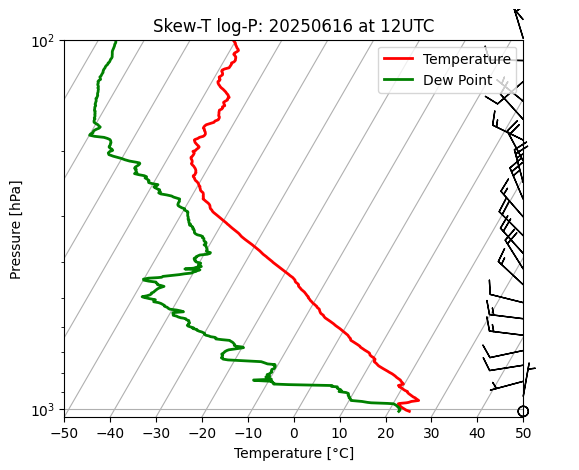

In [25]:

# Plot
skew = SkewT()

skew.plot(pressure, temperature, 'r', linewidth=2, label='Temperature')
skew.plot(pressure, dewpoint, 'g', linewidth=2, label='Dew Point')
skew.plot_barbs(pressure_barb, u_barb, v_barb)

skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-50, 50)
skew.ax.set_yscale('log')
skew.ax.grid(True)
skew.ax.legend()

plt.xlabel("Temperature [°C]")
plt.ylabel("Pressure [hPa]")
plt.title(f'Skew-T log-P: {date_sounding} at {time_sounding_utc}')
plt.tight_layout()
plt.show()



